In [3]:
%load_ext autoreload
%autoreload 2

from pathlib import Path

import torch
import zarr
import numpy as np
import pandas as pd
import scipy.ndimage
import matplotlib.pyplot as plt
from omegaconf import OmegaConf
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

from brainage.model.model3d import AgeModel3DVolume
from brainage.dataset.dataset3d import BrainDataset

In [4]:
cfg = OmegaConf.load('../../config/config3d.yaml')

In [5]:
cfg.dataset
data_path = cfg.dataset.data
data_group = cfg.dataset.group
info = cfg.dataset.info
infocolumn = cfg.dataset.column
val_set = cfg.dataset.val
crop_size = cfg.dataset.crop_size
val_keys = [l.strip() for l in Path(val_set).open().readlines()]

In [6]:
if np.any(crop_size):
    val_transform = CenterCropTransform(crop_size=crop_size, data_key='data')
else:
    val_transform = None


In [43]:
ds_test = BrainDataset(data=data_path,
                       keys=val_keys[:100],
                        info=info,
                        group=data_group,
                        column=infocolumn,
                        preload=True,
                        transform=val_transform)
loader = DataLoader(ds_test, batch_size=1, num_workers=1, drop_last=False, shuffle=False)

100%|██████████| 100/100 [00:02<00:00, 42.93it/s]


In [44]:
device = torch.device('cuda:0')

In [45]:
ckpt = '/home/raheppt1/projects/brainage/outputs/brainage/debug3d/2020-08-17/15-46-01/brainage/2vq007o2/checkpoints/epoch=89.ckpt'
model = AgeModel3DVolume.load_from_checkpoint(ckpt, train_ds=None, val_ds=None)
model.eval()
model.to(device)

AgeModel3DVolume(
  (loss_criterion): l2_loss()
  (net): ResNet(
    (conv1): Conv3d(1, 64, kernel_size=(7, 7, 7), stride=(2, 2, 2), padding=(3, 3, 3), bias=False)
    (bn1): VarNorm3d(
      (layer): InstanceNorm3d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    )
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool3d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer3): Sequential(
      (0): BasicBlock(
        (conv1): Conv3d(64, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (bn1): VarNorm3d(
          (layer): InstanceNorm3d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        )
        (relu): ReLU(inplace=True)
        (conv2): Conv3d(256, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (bn2): VarNorm3d(
          (layer): InstanceNorm3d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        )
        (d

In [46]:
out_dir = Path('/mnt/qdata/raheppt1/data/brainage/nako/processed/gradcam')
out_dir = out_dir/f'{cfg.project.job}_{cfg.dataset.mode}'
out_dir.mkdir(exist_ok=True)

In [53]:
store = zarr.DirectoryStore(out_dir/'test.zarr')
root = zarr.group(store=store, overwrite=True)
heatmaps = root.create_group('heatmaps', overwrite=True)
heatmaps_sigma = root.create_group('heatmaps_sigma', overwrite=True)
images = root.create_group('images', overwrite=True)

In [57]:
results = {'key': [], 'y': [], 'y_hat0': [], 'y_hat1': []}
for sample in tqdm(loader):
    x = sample['data'].float()
    x = x.to(device)
    y = sample['label'][0].float()
    key = sample['key'][0]
    y_hat, heatmap = model.gradcam(x, channel=0)

    # store heatmap/image to zarr
    hmap = heatmap.cpu().numpy().astype(np.float32)
    ds = heatmaps.zeros(key ,shape=hmap.shape, chunks=False, dtype=hmap.dtype)
    ds[:] = hmap 
    img = x.cpu().numpy().astype(np.float16)[0,0]
    ds = images.zeros(key ,shape=img.shape, chunks=False, dtype=img.dtype)
    ds[:] = img 
    
    # store prediction
    results['key'].append(key)
    results['y'].append(y.item())
    results['y_hat0'].append(y_hat[0, 0].detach().cpu().item())
    results['y_hat1'].append(y_hat[0, 1].detach().cpu().item())
df = pd.DataFrame.from_dict(results)

In [54]:
results = {'key': [], 'y': [], 'y_hat0': [], 'y_hat1': []}
for sample in tqdm(loader):
    x = sample['data'].float()
    x = x.to(device)
    y = sample['label'][0].float()
    key = sample['key'][0]
    y_hat, heatmap = model.gradcam(x, channel=1)

    # store heatmap/image to zarr
    hmap = heatmap.cpu().numpy().astype(np.float32)
    ds = heatmaps_sigma.zeros(key ,shape=hmap.shape, chunks=False, dtype=hmap.dtype)
    ds[:] = hmap 

In [27]:
df

,key,y,y_hat0,y_hat1
0,100000,52.0,52.081059,1.257820
1,100002,25.0,34.060371,1.739873
2,100003,64.0,65.531815,1.131558
3,100004,45.0,46.399479,1.272278
4,100005,65.0,65.462105,1.118805
...,...,...,...,...
495,100532,64.0,62.641003,1.125063
496,100533,64.0,65.603882,1.116694
497,100534,53.0,51.366222,1.297943
498,100535,31.0,34.023556,1.703843


Text(0, 0.5, 'predicted age')

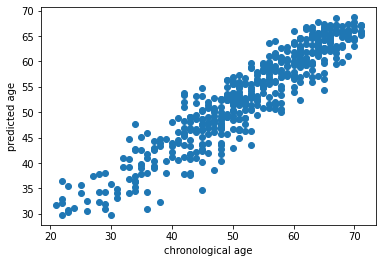

In [32]:
plt.scatter(x=df['y'], y=df['y_hat0'])
plt.xlabel('chronological age')
plt.ylabel('predicted age')

Text(0, 0.5, 'prediction error')

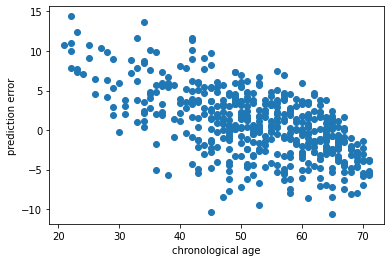

In [34]:
plt.scatter(x=df['y'], y=df['y_hat0']-df['y'])
plt.xlabel('chronological age')
plt.ylabel('prediction error')

Text(0, 0.5, 'prediction error')

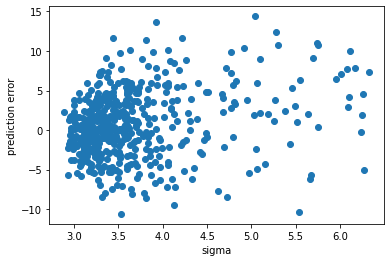

In [36]:
plt.scatter(x=np.exp(df['y_hat1']), y=df['y_hat0']-df['y'])
plt.xlabel('sigma')
plt.ylabel('prediction error')

Text(0.5, 0, 'predicted sigma')

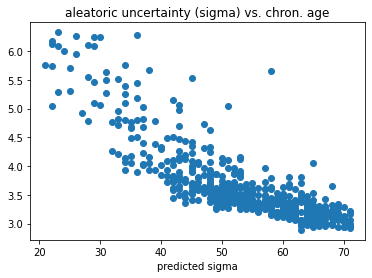

In [31]:
plt.scatter(x=df['y'], y=np.exp(df['y_hat1']))
plt.title('aleatoric uncertainty (sigma) vs. chron. age')
plt.xlabel('chron. age')
plt.ylabel('predicted sigma')

In [73]:
store = zarr.DirectoryStore(out_dir/'test.zarr')
with zarr.open(store=store, mode='r') as zf:
    hmap = zf['heatmaps']['100000'][:].astype(np.float32)
    #hmap = zf['heatmaps_sigma']['100000'][:].astype(np.float32)
    img = zf['images']['100000'][:].astype(np.float32)

In [79]:
# resize heatmap
hmap = hmap/hmap.max()
zoom = np.array(img.shape)/np.array(hmap.shape)
heatmap_zoomed = scipy.ndimage.zoom(hmap, zoom, order=3)
print(hmap.shape, heatmap_zoomed.shape)
heatmap_max = heatmap_zoomed.max()
heatmap_min = heatmap_zoomed.min()
print(heatmap_min, heatmap_max)

(25, 32, 27) (100, 125, 105)
0.01567848 1.025708


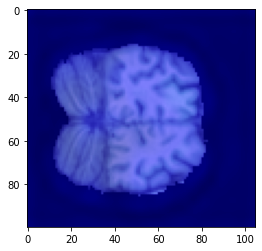

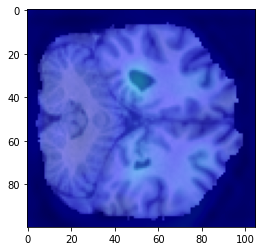

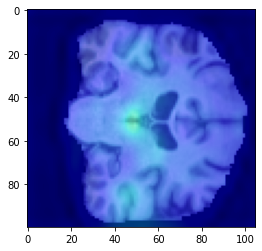

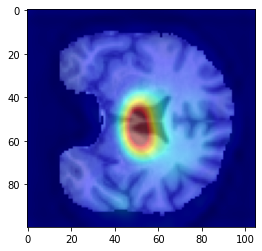

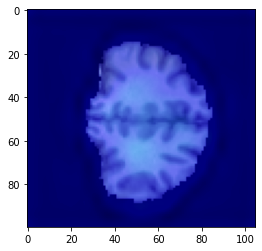

In [84]:
for slice in [20, 40, 60, 80, 100]:
    plt.imshow(img[:,slice,:], cmap='bone')
    plt.imshow(heatmap_zoomed[:,slice,:], alpha=0.5, cmap='jet', vmin=0.0, vmax=0.5)
    plt.show()